# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [ ]:
library(tidyverse, warn.conflicts=FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'jsonlite'

The following object is masked from 'package:purrr':

    flatten

In [ ]:
options(fig.width=5, fig.height=4)

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of
the integration. Let’s load those:

In [ ]:
link_stats = read_csv("book-links/gender-stats.csv")

Rows: 46 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, gender
dbl (2): n_books, n_actions

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 46
Columns: 4
$ dataset   <chr> "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-…
$ gender    <chr> "no-author-rec", "no-book-author", "female", "ambiguous", "m…
$ n_books   <dbl> 306291, 600216, 743105, 73989, 2424008, 1084460, 9528, 10861…
$ n_actions <dbl> NA, NA, NA, NA, NA, NA, 104008, 18882, 47275, 468156, 18597,…

Now let’s define variables for our variou codes. We are first going to
define our gender codes. We’ll start with the resolved codes:

In [ ]:
link_codes = c('female', 'male', 'ambiguous', 'unknown')

We want the unlink codes in order, so the last is the first link
failure:

In [ ]:
unlink_codes = c('no-author-rec', 'no-book-author', 'no-book')

In [ ]:
all_codes = c(link_codes, unlink_codes)

## Processing Statistics

Now we’ll pivot each of our count columns into a table for easier
reference.

In [ ]:
book_counts = link_stats %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_books) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(book_counts)

Rows: 7
Columns: 9
$ dataset          <chr> "LOC-MDS", "BX-I", "BX-E", "AZ14", "AZ18", "GR-I", "G…
$ `no-author-rec`  <dbl> 306291, 11562, 5692, 155511, 239917, 61601, 60515
$ `no-book-author` <dbl> 600216, 10861, 5428, 167948, 152438, 750118, 738282
$ female           <dbl> 743105, 71441, 40256, 248863, 318004, 228142, 225840
$ ambiguous        <dbl> 73989, 9528, 5596, 24064, 27977, 18709, 18516
$ male             <dbl> 2424008, 102756, 58484, 550877, 670899, 338411, 334136
$ unknown          <dbl> 1084460, 31440, 15281, 239915, 300300, 108333, 106501
$ `no-book`        <dbl> 0, 35009, 17481, 870268, 1144899, 0, 0
$ total            <dbl> 5232069, 272597, 148218, 2257446, 2854434, 1505314, 1…

In [ ]:
act_counts = link_stats %>%
    filter(dataset != "LOC-MDS") %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_actions) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(act_counts)

Rows: 6
Columns: 9
$ dataset          <chr> "BX-I", "BX-E", "AZ14", "AZ18", "GR-I", "GR-E"
$ ambiguous        <dbl> 104008, 41768, 849025, 1844630, 22091068, 13230835
$ `no-book-author` <dbl> 18882, 7234, 2359170, 2820794, 29784689, 11168052
$ `no-book`        <dbl> 47275, 19920, 3879190, 10008921, 0, 0
$ male             <dbl> 468156, 183945, 7105363, 15603235, 69977512, 33249747
$ `no-author-rec`  <dbl> 18597, 7130, 1100127, 3312340, 3545964, 1039410
$ female           <dbl> 401483, 142252, 4977284, 12377052, 82889862, 36335167
$ unknown          <dbl> 69361, 24554, 2157265, 4692726, 10242726, 3570086
$ total            <dbl> 1127762, 426803, 22427424, 50659698, 218531821, 98593…

We’re going to want to compute versions of this table as fractions,
e.g. the fraction of books that are written by women. We will use the
following helper function:

In [ ]:
fractionalize = function(data, columns, unlinked=NULL) {
    fracs = select(data, dataset | all_of(columns))
    if (!is.null(unlinked)) {
        fracs = mutate(fracs, unlinked=rowSums(select(data, all_of(columns))))
    }
    totals = rowSums(select(fracs, !dataset))
    fracs %>% mutate(across(!dataset, ~ .x / totals))
}
fractionalize(book_counts, link_codes) %>% glimpse()

Rows: 7
Columns: 5
$ dataset   <chr> "LOC-MDS", "BX-I", "BX-E", "AZ14", "AZ18", "GR-I", "GR-E"
$ female    <dbl> 0.1717939, 0.3320289, 0.3365408, 0.2339556, 0.2414279, 0.328…
$ male      <dbl> 0.5603915, 0.4775684, 0.4889272, 0.5178783, 0.5093450, 0.487…
$ ambiguous <dbl> 0.01710506, 0.04428229, 0.04678265, 0.02262252, 0.02124007, …
$ unknown   <dbl> 0.2507096, 0.1461204, 0.1277494, 0.2255436, 0.2279871, 0.156…

And a helper function for plotting bar charts:

In [ ]:
plot_bars = function(data) {
    tall = data %>%
        pivot_longer(!dataset, names_to="status", values_to="fraction")
    codes = c(all_codes, "unlinked")
    codes = intersect(codes, unique(tall$status))
    tall = tall %>% mutate(status=ordered(status, codes))
    ggplot(tall) +
        aes(y=dataset, x=fraction, fill=status) +
        geom_col(position=position_stack(reverse=TRUE)) +
        geom_text(aes(label=sprintf("%.1f%%", fraction * 100)),
                  position=position_stack(reverse=TRUE, vjust=0.5),
                  colour="white", fontface="bold") +
        scale_fill_brewer(type="qual", palette="Dark2")
}

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [ ]:
book_counts %>% fractionalize(all_codes)

# A tibble: 7 × 8
  dataset female  male ambiguous unknown `no-author-rec` `no-book-author`
  <chr>    <dbl> <dbl>     <dbl>   <dbl>           <dbl>            <dbl>
1 LOC-MDS  0.142 0.463   0.0141   0.207           0.0585           0.115 
2 BX-I     0.262 0.377   0.0350   0.115           0.0424           0.0398
3 BX-E     0.272 0.395   0.0378   0.103           0.0384           0.0366
4 AZ14     0.110 0.244   0.0107   0.106           0.0689           0.0744
5 AZ18     0.111 0.235   0.00980  0.105           0.0841           0.0534
6 GR-I     0.152 0.225   0.0124   0.0720          0.0409           0.498 
7 GR-E     0.152 0.225   0.0125   0.0718          0.0408           0.498 
# ℹ 1 more variable: `no-book` <dbl>

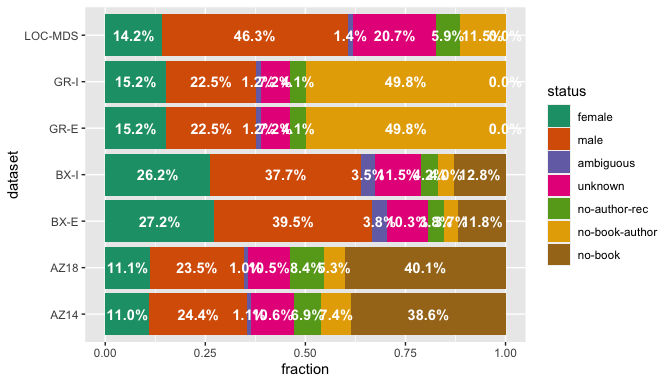

In [ ]:
book_counts %>% fractionalize(all_codes) %>% plot_bars()

In [ ]:
book_counts %>% fractionalize(link_codes, unlink_codes)

# A tibble: 7 × 6
  dataset female  male ambiguous unknown unlinked
  <chr>    <dbl> <dbl>     <dbl>   <dbl>    <dbl>
1 LOC-MDS 0.0859 0.280   0.00855  0.125       0.5
2 BX-I    0.166  0.239   0.0221   0.0731      0.5
3 BX-E    0.168  0.244   0.0234   0.0639      0.5
4 AZ14    0.117  0.259   0.0113   0.113       0.5
5 AZ18    0.121  0.255   0.0106   0.114       0.5
6 GR-I    0.164  0.244   0.0135   0.0781      0.5
7 GR-E    0.165  0.244   0.0135   0.0777      0.5

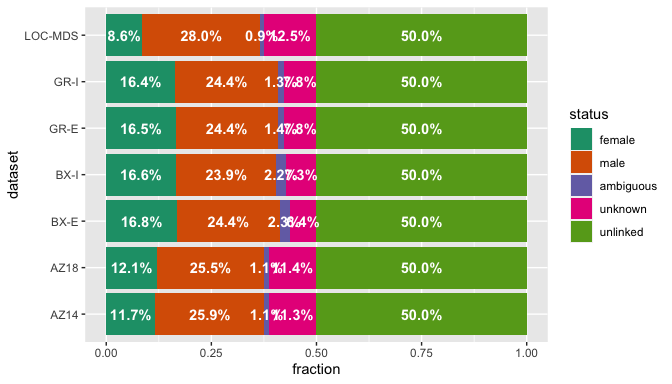

In [ ]:
book_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars()

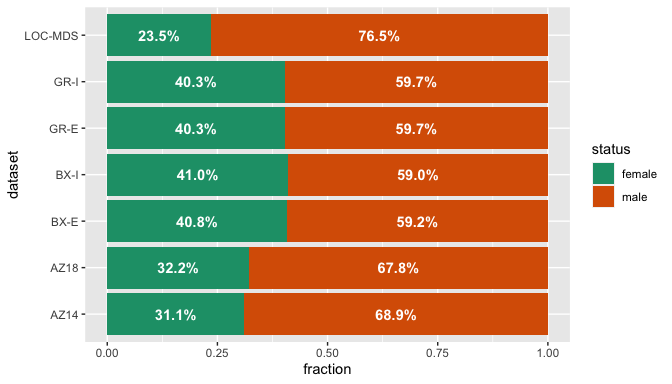

In [ ]:
book_counts %>% fractionalize(c('female', 'male')) %>% plot_bars()

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [ ]:
act_counts %>% fractionalize(all_codes)

# A tibble: 6 × 8
  dataset female  male ambiguous unknown `no-author-rec` `no-book-author`
  <chr>    <dbl> <dbl>     <dbl>   <dbl>           <dbl>            <dbl>
1 BX-I     0.356 0.415    0.0922  0.0615          0.0165           0.0167
2 BX-E     0.333 0.431    0.0979  0.0575          0.0167           0.0169
3 AZ14     0.222 0.317    0.0379  0.0962          0.0491           0.105 
4 AZ18     0.244 0.308    0.0364  0.0926          0.0654           0.0557
5 GR-I     0.379 0.320    0.101   0.0469          0.0162           0.136 
6 GR-E     0.369 0.337    0.134   0.0362          0.0105           0.113 
# ℹ 1 more variable: `no-book` <dbl>

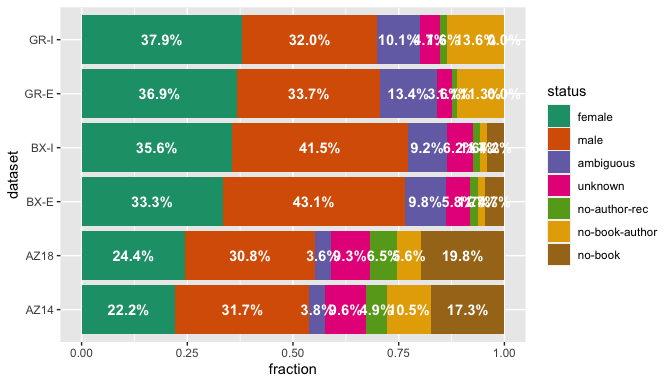

In [ ]:
act_counts %>% fractionalize(all_codes) %>% plot_bars()

In [ ]:
act_counts %>% fractionalize(link_codes, unlink_codes)

# A tibble: 6 × 6
  dataset female  male ambiguous unknown unlinked
  <chr>    <dbl> <dbl>     <dbl>   <dbl>    <dbl>
1 BX-I     0.192 0.224    0.0499  0.0333      0.5
2 BX-E     0.181 0.234    0.0532  0.0313      0.5
3 AZ14     0.165 0.235    0.0281  0.0715      0.5
4 AZ18     0.179 0.226    0.0267  0.0680      0.5
5 GR-I     0.224 0.189    0.0596  0.0277      0.5
6 GR-E     0.210 0.192    0.0766  0.0207      0.5

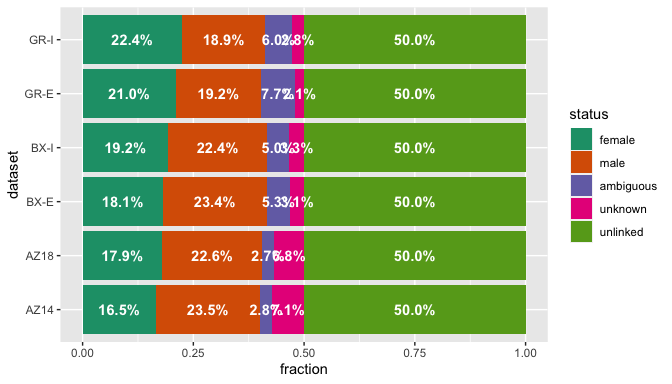

In [ ]:
act_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars()

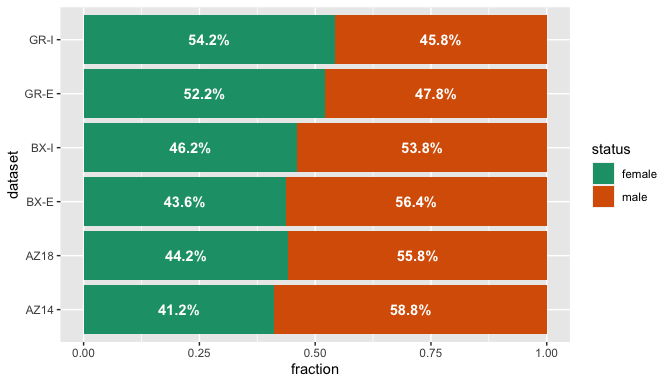

In [ ]:
act_counts %>% fractionalize(c('female', 'male')) %>% plot_bars()

## Metrics

Finally, we’re going to write coverage metrics.

In [ ]:
book_linked = eval(quote(male + female + ambiguous), envir=book_counts)
book_coverage = book_linked / book_counts$total
book_coverage = setNames(book_coverage, book_counts$dataset)
book_coverage

  LOC-MDS      BX-I      BX-E      AZ14      AZ18      GR-I      GR-E 
0.6194685 0.6739803 0.7039361 0.3649274 0.3562458 0.3887973 0.3898746 

In [ ]:
json = toJSON(
    as.list(book_coverage),
    auto_unbox=TRUE,
)
write_file(json, "book-coverage.json")